# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [162]:
# Install the required libraries
# !pip install prophet

In [163]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
#import datetime as dt
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [164]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Ensure the DataFrame index is set correctly as datetime (if not already)
df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index)

# Review the first and last five rows of the DataFrame
print(df_mercado_trends.head())
print(df_mercado_trends.tail())

/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_19511/1463894796.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


                     Search Trends
Date                              
2016-06-01 00:00:00             97
2016-06-01 01:00:00             92
2016-06-01 02:00:00             76
2016-06-01 03:00:00             60
2016-06-01 04:00:00             38
                     Search Trends
Date                              
2020-09-07 20:00:00             71
2020-09-07 21:00:00             83
2020-09-07 22:00:00             96
2020-09-07 23:00:00             97
2020-09-08 00:00:00             96


In [165]:
# Verify the index type and DataFrame structure
print(df_mercado_trends.index)

# Review the data types of the DataFrame using the info function
print("-----")
print(df_mercado_trends.info())

DatetimeIndex(['2016-06-01 00:00:00', '2016-06-01 01:00:00',
               '2016-06-01 02:00:00', '2016-06-01 03:00:00',
               '2016-06-01 04:00:00', '2016-06-01 05:00:00',
               '2016-06-01 06:00:00', '2016-06-01 07:00:00',
               '2016-06-01 08:00:00', '2016-06-01 09:00:00',
               ...
               '2020-09-07 15:00:00', '2020-09-07 16:00:00',
               '2020-09-07 17:00:00', '2020-09-07 18:00:00',
               '2020-09-07 19:00:00', '2020-09-07 20:00:00',
               '2020-09-07 21:00:00', '2020-09-07 22:00:00',
               '2020-09-07 23:00:00', '2020-09-08 00:00:00'],
              dtype='datetime64[ns]', name='Date', length=37106, freq=None)
-----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
me

<Axes: xlabel='Date'>

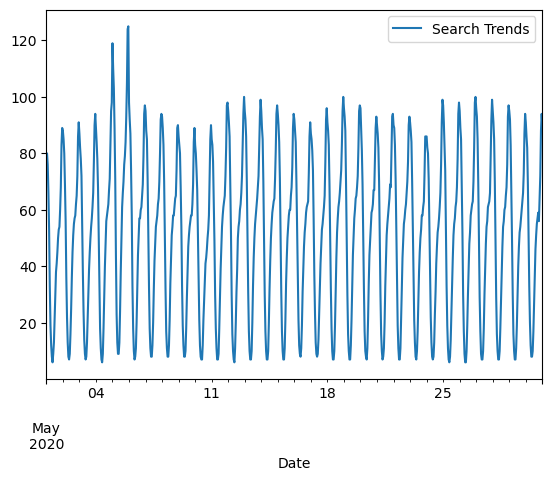

In [166]:
# Slice the DataFrame to just the month of May 2020
just_may = df_mercado_trends.loc['2020-05-01 00:00:00': '2020-05-31 00:00:00']

# Plot to visualize the data for May 2020
just_may.plot()


**Observation**:<br>
- Spikes appear in the Search Trend on May 5th and the 6th.
- The trend generally oscillates in a predictable pattern and across a flat mean. 

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [167]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_mercado_trends.loc['2020-05', 'Search Trends'].sum()

# View the traffic_may_2020 value
print("Traffic for May 2020:", traffic_may_2020)


Traffic for May 2020: 38181


In [168]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_sums = df_mercado_trends.resample('M').sum()
median_monthly_traffic = monthly_sums['Search Trends'].median()

# View the median_monthly_traffic value
print("Median monthly traffic:", median_monthly_traffic)


Median monthly traffic: 35172.5


/var/folders/h3/xtqxxtn9551c8dd44chd8lbc0000gn/T/ipykernel_19511/3729763597.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sums = df_mercado_trends.resample('M').sum()


In [169]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
comparison_ratio = traffic_may_2020 / median_monthly_traffic
print("Comparison Ratio (May 2020 / Median):", comparison_ratio)

Comparison Ratio (May 2020 / Median): 1.0855355746677091


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**<br>
Yes, there seems to be an increase in search traffic during the month that MELI released its financial results.  A spike can be observed on the 5th and 6th.

The comparison ratio for May 2020 is approximately 1.086, which indicates that there was 86% higher than average monthly search traffic in May.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: xlabel='hour_of_day'>

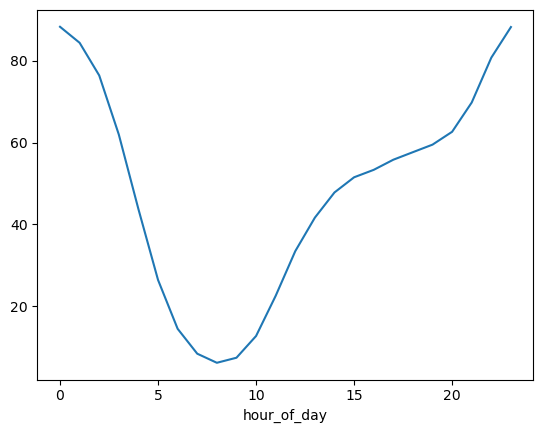

In [170]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`

# Extract the hour from the datetime index
df_mercado_trends['hour_of_day'] = df_mercado_trends.index.hour

# Group by this new column and calculate the mean of search trends
average_traffic_by_hour = df_mercado_trends.groupby('hour_of_day')['Search Trends'].mean()

# Plotting the result
average_traffic_by_hour.plot()


Observation:<br>
Peak time of day seems to occur between the 20th and 4th hours.

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Axes: xlabel='day_of_week'>

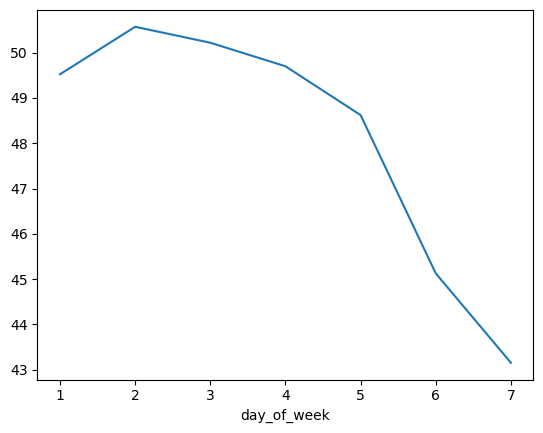

In [171]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.

# Extract the day of the week using isocalendar().day
df_mercado_trends['day_of_week'] = df_mercado_trends.index.isocalendar().day

# Calculate the average search traffic for each day of the week
average_traffic_by_day = df_mercado_trends.groupby('day_of_week')['Search Trends'].mean()

# Plotting the results
average_traffic_by_day.plot()

Observation:<br>
The 2nd day is the busiest.<br>
Then the 3rd day followed by the 4th and the 1st days.

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Axes: xlabel='week_of_year'>

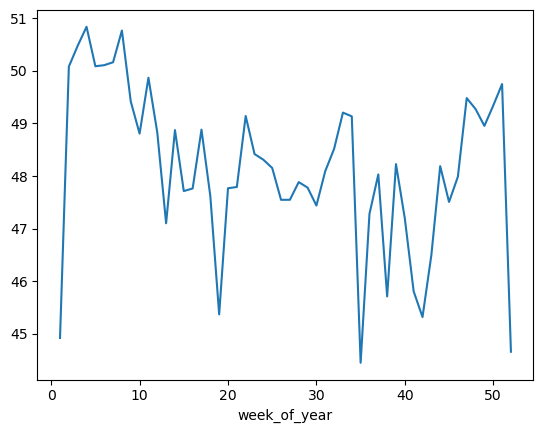

In [172]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.

# Extract the week of the year using isocalendar().week
df_mercado_trends['week_of_year'] = df_mercado_trends.index.isocalendar().week

# Calculate the average search traffic for each week of the year
average_traffic_by_week = df_mercado_trends.groupby('week_of_year')['Search Trends'].mean()

# Plotting the results
average_traffic_by_week.plot()


Observation:<br>
Spikey behavior across weeks.<br>
Spike highs in weeks 5 to 10, 20 to 24, 30 to 33, 42 to 50.<br>
Spike lows included: 17 to 19, 34 to 36, 37 to 38, and 40 to 42.

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**
- Peaks seem to occur between the 20th and 4th hours of the day.
- Busiest on the 1st, 2nd and 3rd days of the week.
- Spikey behavior across weeks showing a slight down-trend between weeks 0 to 35 before recovering slightly between weeks 42 and 50. 
    - Spike highs in weeks 5 to 10, 20 to 24, 30 to 33, 42 to 50. 
    - Spike lows included: 17 to 19, 34 to 36, 37 to 38, and 40 to 42.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [173]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# Ensure the DataFrame index is set correctly as datetime (if not already)
df_mercado_stock.index = pd.to_datetime(df_mercado_stock.index)

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: xlabel='date'>

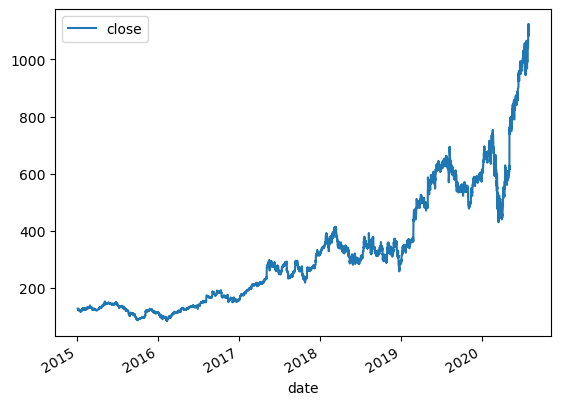

In [174]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock.plot()

In [175]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_combined = pd.concat([df_mercado_stock[['close']], df_mercado_trends[['Search Trends']]], axis=1)
df_combined.dropna(inplace=True)


# View the first and last five rows of the DataFrame
display(df_combined.head())
display(df_combined.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [176]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_combined.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


Text(0.5, 1.0, 'Google Search Trends')

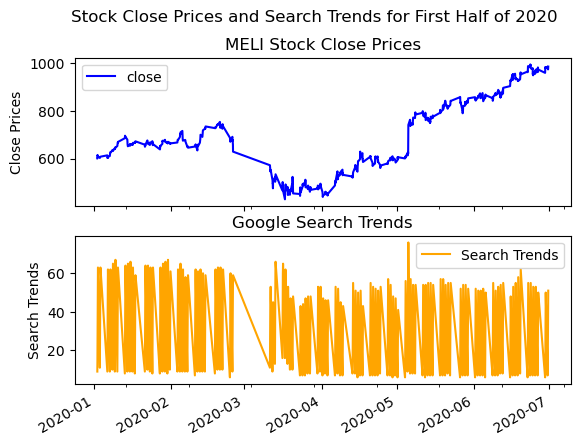

In [177]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
ax = first_half_2020.plot(subplots=True, layout=(2, 1), 
                          title='Stock Close Prices and Search Trends for First Half of 2020', 
                          legend=True, color=['blue', 'orange'])

# Set labels and titles for each subplot
ax[0][0].set_ylabel('Close Prices')
ax[0][0].set_title('MELI Stock Close Prices')
ax[1][0].set_ylabel('Search Trends')
ax[1][0].set_title('Google Search Trends')


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**
In general, at this timescale, 'Close Prices' appear to go up or down and its moving average would follow that trend, while 'Search Trends' seem to oscillate around a more static/stable average over the same time series.

There is a 'Search Trend' all time high spike in this timeframe, which aligns to a dramatic 'Price Close' spike in May.

Yes, the 'Close Price' chart indicates that the narrative is correct, stock investors recognized new customer and revenue growth e-commerce company, MELI. 

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [178]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df = df_combined.copy()
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)

mercado_stock_trends_df.head()


,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


In [179]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Returns'] = mercado_stock_trends_df['close'].pct_change()
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['Returns'].rolling(window=4).std()

mercado_stock_trends_df.head()

,close,Search Trends,Lagged Search Trends,Returns,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,0.010876,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,-0.000512,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,-0.001025,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,-0.002346,0.006134


Axes(0.125,0.2;0.775x0.68)


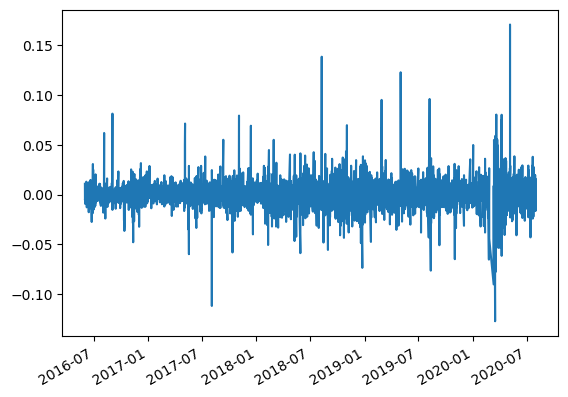

In [180]:
# Visualize the stock volatility
#print(mercado_stock_trends_df['Stock Volatility'].plot())
print(mercado_stock_trends_df['Returns'].plot())


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [181]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change() * 100
mercado_stock_trends_df.columns


Index(['close', 'Search Trends', 'Lagged Search Trends', 'Returns',
       'Stock Volatility', 'Hourly Stock Return'],
      dtype='object')

In [182]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
mercado_stock_trends_df

,close,Search Trends,Lagged Search Trends,Returns,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.160,6.0,NaN,NaN,NaN,NaN
2016-06-01 10:00:00,136.630,12.0,6.0,0.010876,NaN,1.087600
2016-06-01 11:00:00,136.560,22.0,12.0,-0.000512,NaN,-0.051233
2016-06-01 12:00:00,136.420,33.0,22.0,-0.001025,NaN,-0.102519
2016-06-01 13:00:00,136.100,40.0,33.0,-0.002346,0.006134,-0.234570
...,...,...,...,...,...,...
2020-07-31 11:00:00,1105.780,20.0,11.0,0.006380,0.012837,0.637986
2020-07-31 12:00:00,1087.925,32.0,20.0,-0.016147,0.013549,-1.614697
2020-07-31 13:00:00,1095.800,41.0,32.0,0.007239,0.013295,0.723855
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013552,0.013001,1.355174


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [183]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** 
The correlation coefficients do not indicate any strong or highly predictable relationships among the variables. Given the weak correlations, it appears that lagged search traffic does not have a strong or predictable relationship with either stock volatility or hourly stock returns. Other factors may be more influential in driving stock price and volatility, or that the relationships may not be linear and could require more complex models or different types of analyses.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [184]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_trends = df_mercado_trends.drop(columns=['hour_of_day', 'day_of_week', 'week_of_year'])
mercado_prophet_df = df_mercado_trends.rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df.dropna(inplace=True)

# View the first and last five rows of the mercado_prophet_df DataFrame
mercado_prophet_df

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38
...,...,...
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97


In [185]:
# Call the Prophet function, store as an object
m = Prophet()

In [186]:
# Fit the time-series model.
m.fit(mercado_prophet_df)

15:25:39 - cmdstanpy - INFO - Chain [1] start processing
15:25:49 - cmdstanpy - INFO - Chain [1] done processing


In [187]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future = m.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
future.tail()

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [188]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast = m.predict(future)

# Display the first five rows of the forecast_mercado_trends DataFrame
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

                   ds       yhat  yhat_lower  yhat_upper
0 2016-06-01 00:00:00  89.664572   81.271446   97.291582
1 2016-06-01 01:00:00  86.111202   77.271768   94.829254
2 2016-06-01 02:00:00  75.788545   67.555358   83.772032
3 2016-06-01 03:00:00  60.522136   51.815104   68.659673
4 2016-06-01 04:00:00  43.408043   35.270152   52.166809


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


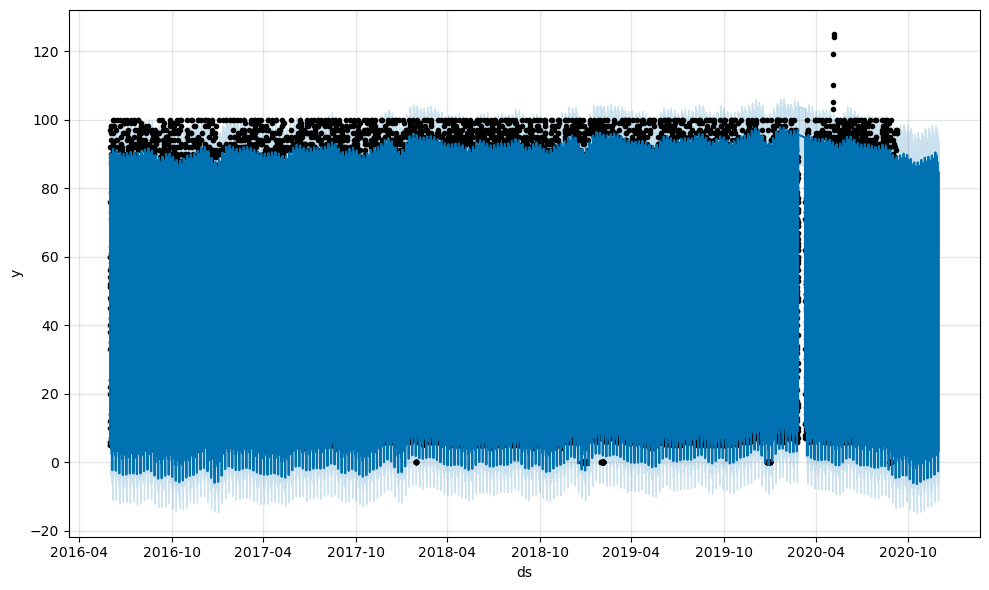

In [189]:
# Plot the Prophet predictions for the Mercado trends data
# Plot the forecast with the historical data using Prophet's plot function
fig1_forecast = m.plot(forecast)

/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

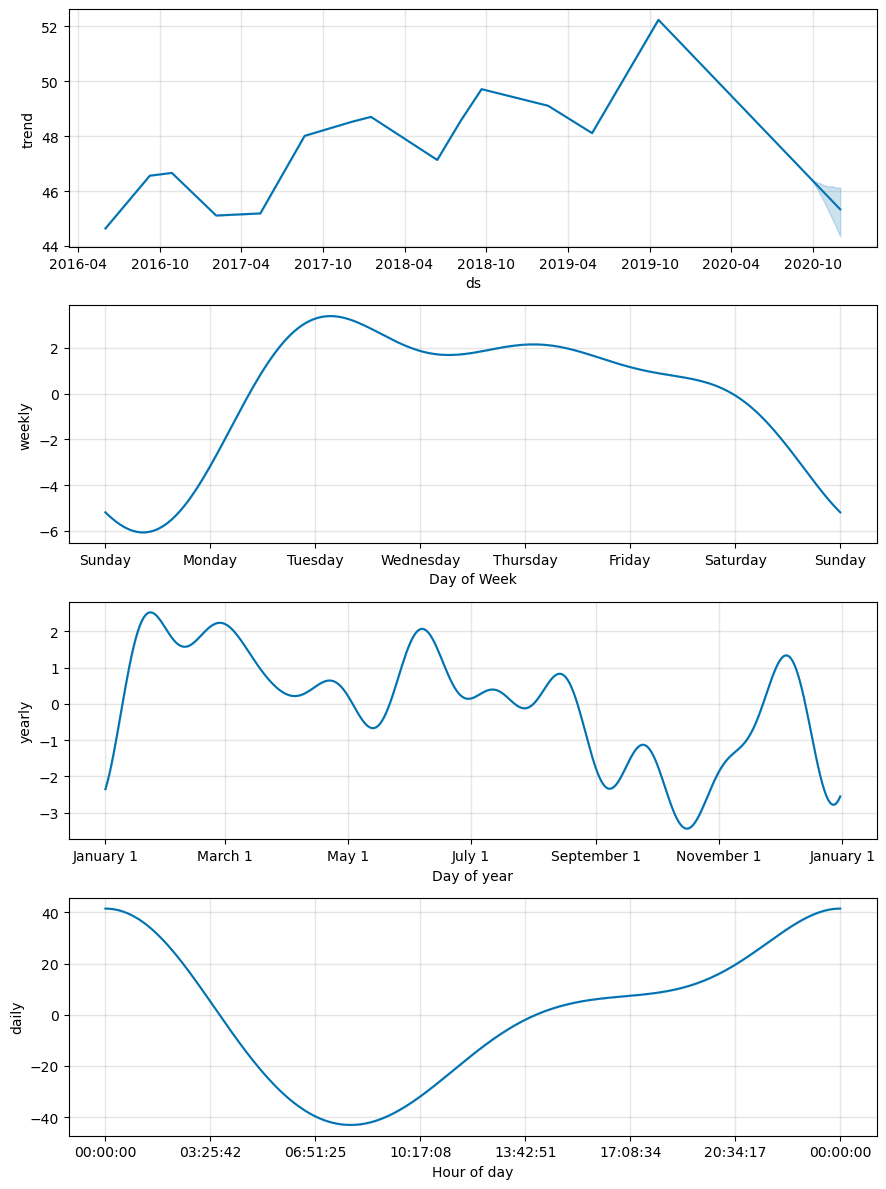

In [190]:
# plot the forecast components (trend, yearly, weekly, daily seasonality)
# For the component plots using plotly:
fig2_components = m.plot_components(forecast)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**
Using this metric alone, the near-term forecast for MELI's popularity is expected to be down.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [191]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecasted_values = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]
forecasted_values


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.664572,81.271446,97.291582
2016-06-01 01:00:00,86.111202,77.271768,94.829254
2016-06-01 02:00:00,75.788545,67.555358,83.772032
2016-06-01 03:00:00,60.522136,51.815104,68.659673
2016-06-01 04:00:00,43.408043,35.270152,52.166809
...,...,...,...
2020-11-30 04:00:00,40.045741,32.258951,48.763363
2020-11-30 05:00:00,24.574646,15.725144,32.550664
2020-11-30 06:00:00,12.609031,4.067343,21.524270


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

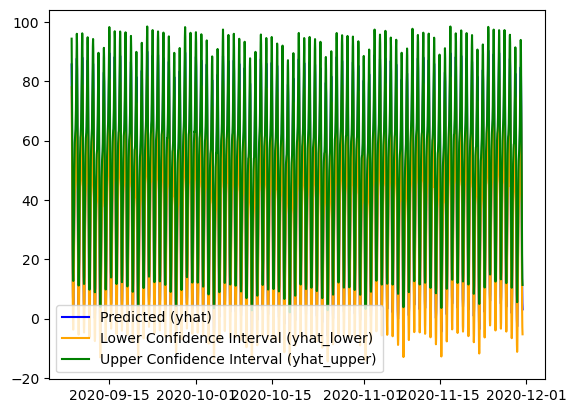

In [192]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
last_2000_hours = forecast_mercado_trends.iloc[-2000:]

plt.plot(last_2000_hours.index, last_2000_hours['yhat'], label='Predicted (yhat)', color='blue')
plt.plot(last_2000_hours.index, last_2000_hours['yhat_lower'], label='Lower Confidence Interval (yhat_lower)', color='orange')
plt.plot(last_2000_hours.index, last_2000_hours['yhat_upper'], label='Upper Confidence Interval (yhat_upper)', color='green')
plt.legend()


/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/davidkaplan/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

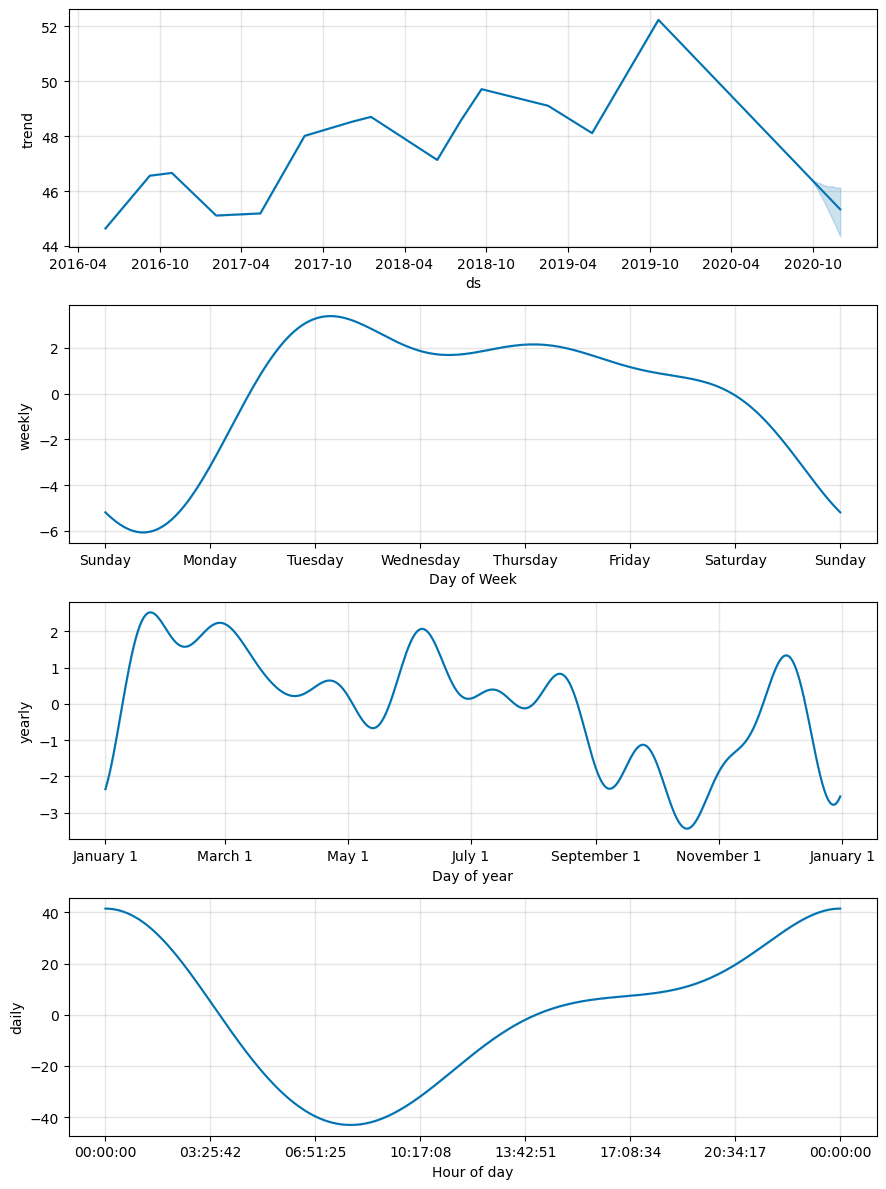

In [193]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)


# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
fig3_components = m.plot_components(forecast_mercado_trends)


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**
The peak popularity is at the zero hour for this dataset.  There is a rapid ascent between 20:34:17 and 00:00:00 then a rapid decline from 00:00:00 to 03:25:42.

**Question:** Which day of week gets the most search traffic?
   
**Answer:**<br>
Tuesday received the most traffic.<br>
Thursdays came in second and <br>
Wednesday is a very close third.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**
Mid-October is the lowest point for search traffic in the calendar year for this dataset.